# Ship Detection

### Introduction

The objective of this project is to develop a machine learning model capable of identifying ships in satellite images. This is particularly challenging due to the diverse size, shape, and appearance of ships, as well as varying lighting and weather conditions which can obscure the ships. Utilizing satellite imagery from the Airbus Ship Detection Challenge dataset, this project aims to automate the detection process, which is critical for applications in maritime surveillance, traffic monitoring, and ecological studies.

### Dataset

The dataset used in this project consists of satellite images provided by Airbus for their Ship Detection Challenge. Each image is 768x768 pixels and is labeled as either containing a ship or not. The images depict a variety of sea and port scenes under different weather and lighting conditions. This dataset provides a comprehensive environment to train and evaluate our model's performance in realistic scenarios.

### Model

A pre-trained ResNet50 model, originally developed for the ImageNet challenge, is adapted for this binary classification task. ResNet50 is chosen for its deep residual learning framework, which helps in learning from a large number of training layers without degrading the network performance. This is crucial for maintaining accuracy given the complexity of the image data and the task.

### Methodology

**Data Preprocessing:** Resize and normalize images to fit the input requirement of ResNet50. Data was augmented through techniques such as rotation, brightness and contrast adjustments, and flipping to enhance model robustness.

**Model Training:** Fine-tune the pre-trained ResNet50 on the Airbus dataset, adjusting the final layers for binary classification.

**Evaluation:** Measure model performance using accuracy metrics and a confusion matrix.

### Objectives

Achieve high accuracy in ship detection to aid in effective maritime surveillance. This model could then be used to monitor activity at important ports and potentially estimate economic activity.

### Expected Outcomes

By the end of this project, we expect to have a fully functional model that can accurately detect the presence of ships in satellite images. This model could potentially be integrated into a larger system for real-time maritime monitoring, providing valuable insights for navigation safety, maritime logistics, and environmental monitoring.

## Further Enhancements

**Improving Model Accuracy:** Implement more complex image augmentation techniques to help the model generalize better over diverse lighting, weather conditions, and ship orientations. Explore the use of different architectures for potentially better feature extraction.

**Multiple Stage Model:** Add a second stage to the model pipeline which attempts to count the number of ships in each image. This could then be used to monitor ship activity in particular ports to estimate economic activity. 

#### Load packages

In [18]:
import pandas as pd
import numpy as np
import os
import zipfile
from PIL import ImageFile, Image
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#### Utility Code

In [2]:
# Set environment variables for proxy configuration
os.environ['http_proxy'] = 'http://lon3.sme.zscaler.net:443'
os.environ['https_proxy'] = 'http://lon3.sme.zscaler.net:443'

In [3]:
data_dir = './ship_data/'
segmentation_dir = './train_ship_segmentations.csv'

#### Utility Functions

In [4]:
# check for ship presence
def has_ship(image_id, df):
    """
    Check if the image identified by `image_id` contains a ship by examining the 'EncodedPixels' column.
    """
    encoded_pixels = df.loc[image_id, 'EncodedPixels']
    # Handle cases where 'EncodedPixels' could be a Series of multiple entries
    if isinstance(encoded_pixels, pd.Series):
        return not encoded_pixels.isna().any() and not (encoded_pixels.str.strip() == "").any()
    else:
        # Handle the case for a single entry (string)
        return pd.notna(encoded_pixels) and encoded_pixels.strip() != ""

In [5]:
# get ship masks (whhich identify location of ships
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [6]:
# converting masks
def rle_decode(mask_rle, shape):
    '''
    mask_rle: string run-length as single string formatted (starts length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to the correct axis

In [7]:
# function to prepare images in the same way as the model does for testing
def prepare_images(file_paths):
    img_list = []  # List to hold the processed images

    for file_path in file_paths:
        img = Image.open('ship_data/' + file_path)  # Load the image file
        img = img.resize((224, 224))  # Resize image to 224x224

        # Convert the image to a numpy array
        img_array = image.img_to_array(img)

        # Apply the same preprocessing used in the training generator
        img_array = tf.image.adjust_contrast(img_array, 0.95)  # Removed randomness for consistent prediction
        img_array = tf.image.adjust_brightness(img_array, 0.95)  # Adjust brightness

        # Rescale the image as done in the ImageDataGenerator
        img_array = img_array / 255.0

        # Append processed image array to list
        img_list.append(img_array)

    # Stack images into a single numpy array
    batch = np.stack(img_list, axis=0)
    return batch

In [8]:
# Function to plot images and their labels
def plot_images(indices, file_paths, true_labels, pred_labels):
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices[:10]):  # Just show 10 images
        img_path = file_paths[index]
        image = Image.open('ship_data/' + img_path)  # Load the image from the file path
        image = np.array(image)  # Convert image to numpy array if necessary
        image = image/255.0
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.astype('float32'))  # Ensure correct data type for displaying
        # plt.title(f"True: {true_labels[index]}, Pred: {pred_labels[index]}")
        plt.title(f"Index: {index}")
        plt.axis('off')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()



In [9]:
# function to load individual images
def load_image(file_paths, index):
    img_path = file_paths[index]
    image = Image.open('ship_data/' + img_path)  # Load the image from the file path
    image = np.array(image)  # Convert image to numpy array if necessary
    image = image/255.0
    return image

## Obtain Data Set

In [10]:
train_names = [f for f in os.listdir(data_dir)if f.endswith('.jpg')]
segmentation_df = pd.read_csv(segmentation_dir).set_index('ImageId')
print(train_names[0:9])
print(len(train_names))

['0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg', '00021ddc3.jpg', '0002756f7.jpg', '0002d0f32.jpg', '000303d4d.jpg', '00031f145.jpg']
192555


## Partition Data

In [11]:
# split data
train_names, test_names = train_test_split(train_names, test_size=0.2, random_state=1)
train_names, val_names = train_test_split(train_names, test_size=0.1, random_state=1)

print(len(train_names))
print(len(test_names))
print(len(val_names))

138639
38511
15405


## Explore, Clean & Process
View an image and mask

Plot the ship count distribution

Save the training data images in ship and no ship folders

Remove some of the no ship data to even up the classes

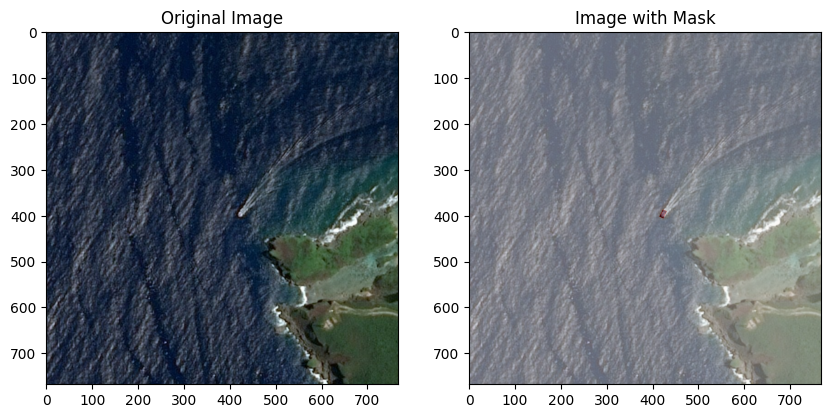

In [12]:
# View an image and mask
example_file = train_names[25]
image_view = Image.open('ship_data/' + example_file)
image_view = np.array(image_view)
# Display the image
img_shape = image_view.shape[:-1]  # height, width

# Create a figure to display the results
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(image_view)
plt.title('Original Image')

encoded_pixels = segmentation_df.loc[example_file, 'EncodedPixels']
# Decode and overlay each mask
if not pd.isna(encoded_pixels):  # Check if there are any masks
    all_masks = np.zeros(img_shape)
    
    if isinstance(encoded_pixels, pd.Series):
        for mask in encoded_pixels:
            all_masks += rle_decode(mask, shape=img_shape)
    else:
        all_masks += rle_decode(encoded_pixels, shape=img_shape)
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_view)
    plt.imshow(all_masks, alpha=0.4, cmap='Reds')  # Adjust alpha to see the image behind the mask
    plt.title('Image with Mask')
else:
    plt.subplot(1, 2, 2)
    plt.imshow(image_view)
    plt.title('No Mask Available')

plt.show()

count    231723.000000
mean          1.344472
std           2.755929
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: ship_count, dtype: float64


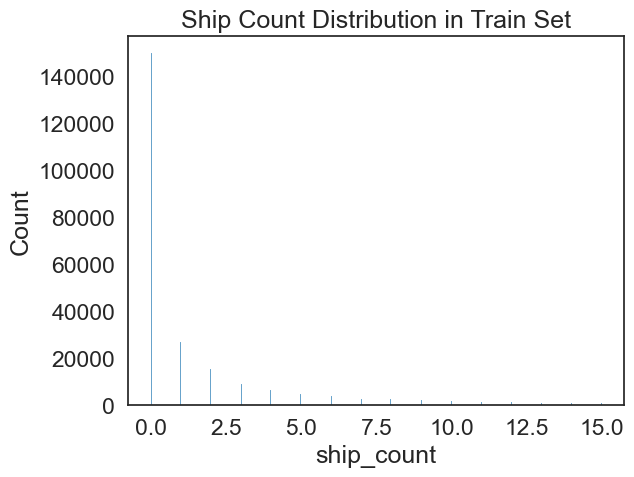

In [13]:
df = segmentation_df
df = df.reset_index()
df['ship_count'] = df.groupby('ImageId')['ImageId'].transform('count')
df.loc[df['EncodedPixels'].isnull().values,'ship_count'] = 0 

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(df['ship_count'],kde=False)
plt.title('Ship Count Distribution in Train Set')

print(df['ship_count'].describe())

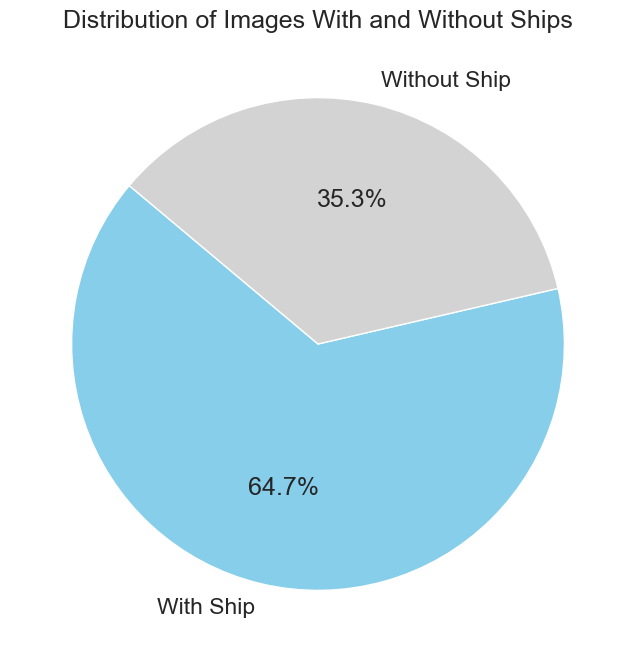

has_ship
False    150000
True      81723
Name: count, dtype: int64


In [14]:
# Categorize images as 'With Ship' or 'Without Ship'
df['has_ship'] = df['ship_count'] > 0

# Calculate the number of images in each category
ship_distribution = df['has_ship'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(ship_distribution, labels=['With Ship', 'Without Ship'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
plt.title('Distribution of Images With and Without Ships')
plt.show()

# Optionally, display the numeric distribution
print(ship_distribution)

In [15]:
# preprocess files
preprocessed_data = []
for name in train_names:
    # Extract image_id from filename
    image_id = name.strip()
    # Check if the image contains a ship
    ship_present = has_ship(image_id, segmentation_df)
    # Append result to the list
    preprocessed_data.append({
        'filename': image_id,
        'has_ship': ship_present
    })
print(preprocessed_data[0:9])


[{'filename': '221ab24a3.jpg', 'has_ship': False}, {'filename': 'f4b9b0cd5.jpg', 'has_ship': False}, {'filename': 'c6ea1c711.jpg', 'has_ship': False}, {'filename': 'df461b337.jpg', 'has_ship': False}, {'filename': 'd17c33130.jpg', 'has_ship': False}, {'filename': '4a8bed5dd.jpg', 'has_ship': False}, {'filename': 'e144afbf1.jpg', 'has_ship': False}, {'filename': '6c5b11961.jpg', 'has_ship': False}, {'filename': 'f0b33514a.jpg', 'has_ship': False}]


In [14]:
# save data in two seperate folders for classification training
# Define source and destination directories
dest_directory = './ship_data/'

# Copy files based on 'has_ship' status
for item in preprocessed_data:
    src_path = os.path.join(dest_directory, item['filename'])
    if item['has_ship']:
        dst_path = os.path.join(dest_directory, 'ship', item['filename'])
    else:
        dst_path = os.path.join(dest_directory, 'no_ship', item['filename'])
    
    # Copy file from src to destination
    shutil.copy(src_path, dst_path)

print("Files have been copied.")

Files have been copied.


In [17]:
# move most of the files out of the folder to even up classes
source_dir = './ship_data/no_ship/'
destination_dir = './removed_no_ship_images/'

files = [file for file in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, file))]
files_to_move = random.sample(files, 77465)

for file in files_to_move:
    src_path = os.path.join(source_dir, file)
    dst_path = os.path.join(destination_dir, file)
    shutil.move(src_path, dst_path)

## Model
Load pretrained ResNet50 model

A layer for binary classification


In [16]:
# Old function
# def build_model(input_shape):
#     weights_path = './models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    
#     # Load the ResNet50 model
#     base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    
#     # Load the weights from the local file
#     base_model.load_weights(weights_path)

#     # # Freeze the convolutional base to prevent weights from being updated during training
#     # for layer in base_model.layers:
#     #     layer.trainable = False

#     # Add custom layers on top for binary classification
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)  # Additional dense layer (optional)
#     output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Specify the input shape expected by ResNet50
# model = build_model((224, 224, 3))
# model.summary()  # Viewing the model structure

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 24,059,393 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
# Define a function to create the model with configurable hyperparameters
weights_path = './models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def build_model(input_shape, learning_rate=0.001, dropout_rate=0.25):
    base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    base_model.load_weights(weights_path)

    # Add custom layers on top for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


## Feature Engineering
Add a custom preprocessing function for loading the images
- This includes resizing and random small adjustments to contrast and brightness
- As well as using the built in functionality to rescale, allow rotation, flip the images etc.

In [20]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Directory where the processed data with 'filename' and 'has_ship' is stored
train_dir = './ship_data/'

def image_preprocessing(image):
    image = tf.image.resize(image, (224, 224))
    # Perturb the contrast and brightness of the image
    contrast = tf.random.uniform([], 0.95, 1.05)  
    brightness = tf.random.uniform([], 0.95, 1.05) 
    image = tf.image.adjust_contrast(image, contrast)
    image = tf.image.adjust_brightness(image, brightness)
    return image

# Setup data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,  # Using 20% of data for validation
    preprocessing_function=image_preprocessing # lambda x: tf.image.resize(x, (224, 224))  # Resize images
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Matching the input size of ResNet
    batch_size=32,
    class_mode='binary',  # Since we're doing binary classification
    subset='training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 49020 images belonging to 2 classes.
Found 12254 images belonging to 2 classes.


## Hyperparameter Selection

### Train
Try many settings but for only one epoch (due to processing time)

In [21]:
# List of hyperparameters to experiment with
hyperparameters = [
    {'learning_rate': 0.001, 'dropout_rate': 0.25, 'batch_size': 32},
    {'learning_rate': 0.0001, 'dropout_rate': 0.25, 'batch_size': 32},
    {'learning_rate': 0.01, 'dropout_rate': 0.25, 'batch_size': 32},
    {'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 32},
    {'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32},
    {'learning_rate': 0.001, 'dropout_rate': 0.25, 'batch_size': 64},
    {'learning_rate': 0.001, 'dropout_rate': 0.25, 'batch_size': 16},
]

In [22]:
# Train and save each model configuration
for i, params in enumerate(hyperparameters):
    print(f"Training model {i+1} with params: {params}")
    model = build_model((224, 224, 3), learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    train_generator.batch_size = params['batch_size']
    validation_generator.batch_size = params['batch_size']

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
    )

    # Save the model
    model.save(f'./models/model_{i+1}.keras')

Training model 1 with params: {'learning_rate': 0.001, 'dropout_rate': 0.25, 'batch_size': 32}


c:\users\fairbr1\pycharmprojects\shipdetection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5421s 4s/step - accuracy: 0.8498 - loss: 0.3776 - val_accuracy: 0.8622 - val_loss: 0.3624
Training model 2 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.25, 'batch_size': 32}
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5433s 4s/step - accuracy: 0.8992 - loss: 0.2528 - val_accuracy: 0.9323 - val_loss: 0.1842
Training model 3 with params: {'learning_rate': 0.01, 'dropout_rate': 0.25, 'batch_size': 32}
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5411s 4s/step - accuracy: 0.5164 - loss: 0.9558 - val_accuracy: 0.5266 - val_loss: 0.7348
Training model 4 with params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 32}
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5438s 4s/step - accuracy: 0.8455 - loss: 0.3843 - val_accuracy: 0.8534 - val_loss: 0.4009
Training model 5 with params: {'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5426s 4s/step - accuracy: 0.8475 - loss: 0.3884 - val_accuracy: 0.8545 - val_loss: 0.3573
Training model 6 

### Test
Process test set

Compare results of different hyperparameters

In [28]:
test_preprocessed_data = []
for name in test_names:
    # Extract image_id from filename
    image_id = name.strip()
    # Check if the image contains a ship
    ship_present = has_ship(image_id, segmentation_df)
    # Append result to the list
    test_preprocessed_data.append({
        'filename': image_id,
        'has_ship': ship_present
    })
print(test_preprocessed_data[0:9])
print(len(test_preprocessed_data))

[{'filename': '33282348d.jpg', 'has_ship': False}, {'filename': 'eb74ba98a.jpg', 'has_ship': False}, {'filename': 'e47881584.jpg', 'has_ship': False}, {'filename': '1b4eb7b17.jpg', 'has_ship': False}, {'filename': '4d1719ed1.jpg', 'has_ship': False}, {'filename': '83b541b28.jpg', 'has_ship': False}, {'filename': 'ada163b2a.jpg', 'has_ship': False}, {'filename': '881368509.jpg', 'has_ship': False}, {'filename': 'c0d8d6031.jpg', 'has_ship': False}]
38511


In [29]:
labels = np.array([d['has_ship'] for d in test_preprocessed_data])
labels = labels.astype(int)  # Convert boolean labels to integers (True to 1, False to 0)

In [ ]:
batch_size = 1000
num_images = len(test_names)
model_accuracies = {}

In [41]:
model = load_model(f'./models/model_7.keras')
model_name = 'model_7'
predictions = []

for i in range(0, num_images, batch_size):
    # Determine the range of images to process
    batch_paths = test_names[i:i+batch_size]
    
    # Prepare images
    prepared_images = prepare_images(batch_paths)
    
    # Predict current batch
    batch_predictions = model.predict(prepared_images)
    
    # Assuming binary classification with a threshold of 0.5
    batch_predicted_classes = (batch_predictions > 0.5).astype(int)
    
    # Store predictions
    predictions.extend(batch_predicted_classes)
    
accuracy = accuracy_score(labels, predictions)
model_accuracies[model_name] = accuracy
print(f'Accuracy for {model_name}: {accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 753ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 739ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 737ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 732ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 737ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 733ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 748ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 716ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 729ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 747ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 723ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 724ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 729ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 728ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 731ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 739ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 746ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 750ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 743ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 733

In [42]:
print(model_accuracies)

{'model_1': 0.9366674456648749, 'model_2': 0.9448728934590117, 'model_3': 0.299109345381839, 'model_4': 0.9062345823271273, 'model_5': 0.8415257978239984, 'model_6': 0.7024746176417127, 'model_7': 0.9144400301212641}


### Results
Model 2 (learning rate = 0.0001, dropout = 0.25, batch = 32) has the highest accuracy after one epoch (0.945).
Followed closely by model 1 (0.001, 0.25, 32), with model 7 slightly behind (0.001, 0.25, 16).

Train model 2 over many epochs.

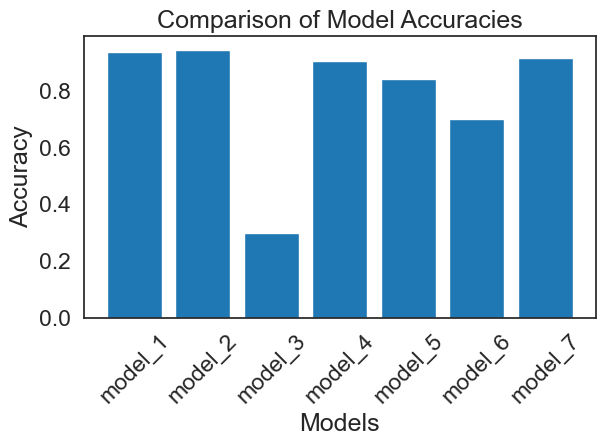

In [43]:
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

## Train Final Model

Learning rate = 0.0001, dropout = 0.25, batch = 32
Number of epochs = 20

Save the mode

In [44]:
model = build_model((224, 224, 3), learning_rate=0.0001, dropout_rate=0.25)
train_generator.batch_size = 32
validation_generator.batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model
model.save(f'./models/ship_classifier_20e_0.0001a_0.25d_32b.keras')

Epoch 1/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5951s 4s/step - accuracy: 0.8991 - loss: 0.2585 - val_accuracy: 0.9278 - val_loss: 0.1946
Epoch 2/20
   1/1531 ━━━━━━━━━━━━━━━━━━━━ 1:25:39 3s/step - accuracy: 0.9375 - loss: 0.1615

C:\Program Files\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1531/1531 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step - accuracy: 0.9375 - loss: 0.1615 - val_accuracy: 0.9333 - val_loss: 0.1231
Epoch 3/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5576s 4s/step - accuracy: 0.9367 - loss: 0.1719 - val_accuracy: 0.9378 - val_loss: 0.1692
Epoch 4/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 4s 574us/step - accuracy: 0.8750 - loss: 0.1832 - val_accuracy: 0.9667 - val_loss: 0.0775
Epoch 5/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5376s 4s/step - accuracy: 0.9427 - loss: 0.1586 - val_accuracy: 0.9369 - val_loss: 0.1807
Epoch 6/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step - accuracy: 0.9375 - loss: 0.1026 - val_accuracy: 0.9333 - val_loss: 0.1463
Epoch 7/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5290s 3s/step - accuracy: 0.9456 - loss: 0.1508 - val_accuracy: 0.9463 - val_loss: 0.1512
Epoch 8/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 4s 452us/step - accuracy: 0.8750 - loss: 0.3685 - val_accuracy: 0.9333 - val_loss: 0.2752
Epoch 9/20
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5285s 3s/step - accuracy: 0.9473 - loss: 0.14

## Test Final Model

Predict in batch (too large for memory)

In [45]:
model = load_model(f'./models/ship_classifier_20e_0.0001a_0.25d_32b.keras')
model_name = 'final_model'
predictions = []

for i in range(0, num_images, batch_size):
    # Determine the range of images to process
    batch_paths = test_names[i:i+batch_size]
    
    # Prepare images
    prepared_images = prepare_images(batch_paths)
    
    # Predict current batch
    batch_predictions = model.predict(prepared_images)
    
    # Assuming binary classification with a threshold of 0.5
    batch_predicted_classes = (batch_predictions > 0.5).astype(int)
    
    # Store predictions
    predictions.extend(batch_predicted_classes)
    
accuracy = accuracy_score(labels, predictions)
print(f'Accuracy for {model_name}: {accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 718ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 691ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 682ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 689ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 695ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 721ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 688ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 683ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 692ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 685ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 690ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 692ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 713ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 721ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 720ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 688ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 696ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 690ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 698ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 685ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 697ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 692ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 689ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 687

## Interpret Results
Confusion matrix

Other performance measures

Investigate false negatives and false positives seperately to identify trends

In [46]:
np_predictions = np.array([pred[0] for pred in predictions])

In [47]:
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[28531  1506]
 [  252  8222]]


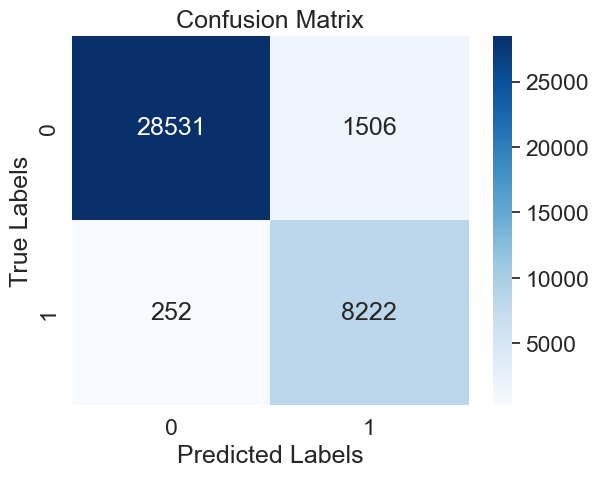

In [48]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.95
Precision: 0.85
Recall: 0.97
F1 Score: 0.90


In [50]:
# Indices of misclassified images
misclassified_indices = np.where(np_predictions != labels)[0]
print(misclassified_indices)


[   15    70    76 ... 38471 38502 38506]


In [52]:
false_positives_indices = np.where((np_predictions==1) & (labels==0))[0]
false_negatives_indices = np.where((np_predictions==0) & (labels==1))[0]
print(len(false_positives_indices))
print(len(false_negatives_indices))

1506
252


False positives


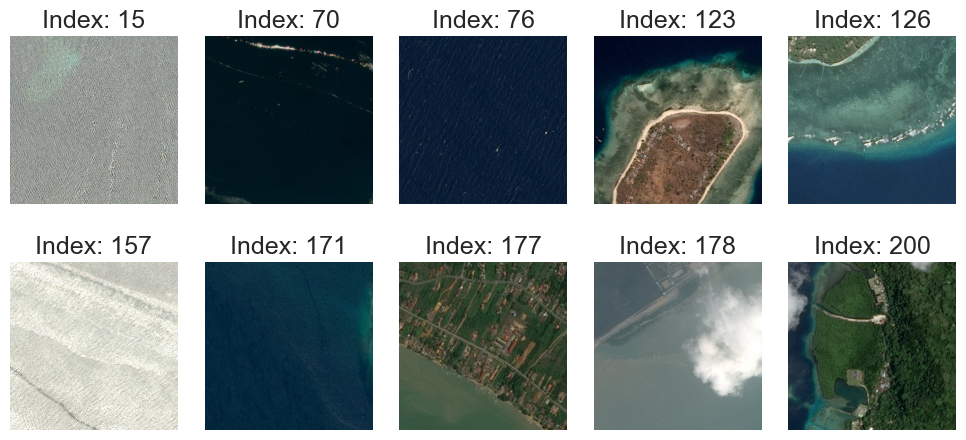

False negatives


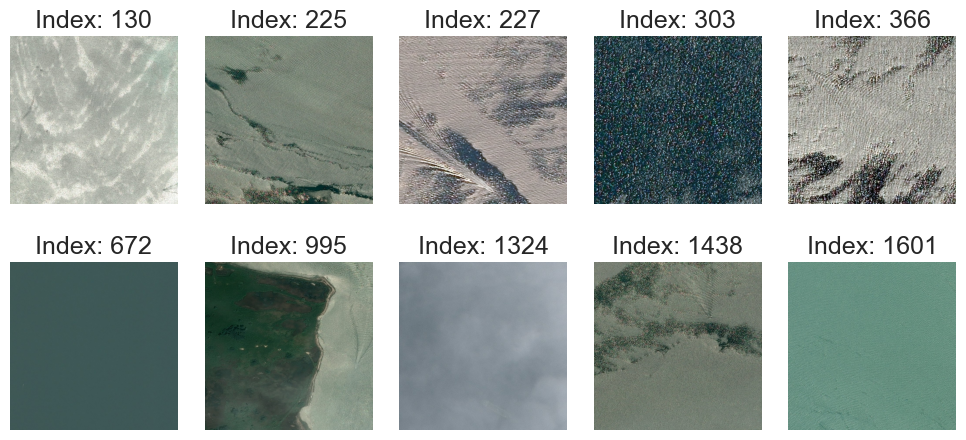

In [53]:
# Call the plotting function
print('False positives')
plot_images(false_positives_indices, test_names, labels, np_predictions) 
print('False negatives')
plot_images(false_negatives_indices, test_names, labels, np_predictions) 

Examples of false positives where it is obvious the features that might have confused the model

Text(0.5, 1.0, 'True: 0, Pred: 1')

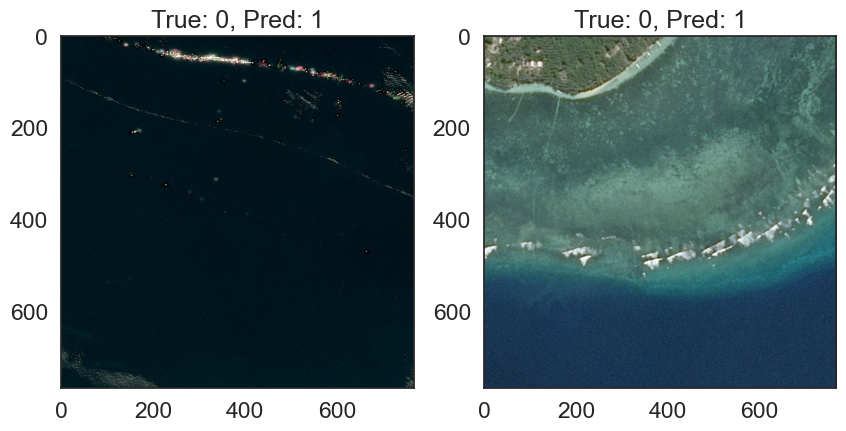

In [57]:
# Create a figure to display the results
plt.figure(figsize=(10, 5))

index_1 = 70
index_2 = 126
image_1 = load_image(test_names, index_1)
image_2 = load_image(test_names, index_2)

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(image_1.astype('float32'))
plt.title(f"True: {labels[index_1]}, Pred: {np_predictions[index_1]}")

plt.subplot(1, 2, 2)
plt.imshow(image_2.astype('float32'))
plt.title(f"True: {labels[index_2]}, Pred: {np_predictions[index_2]}")

Examples of false negatives where it is not obvious if there is a hidden ship or a misclassification

Text(0.5, 1.0, 'True: 1, Pred: 0')

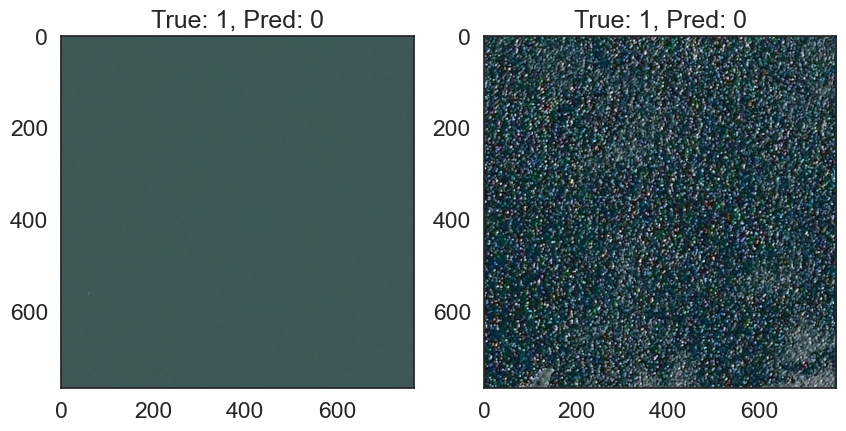

In [65]:
# Create a figure to display the results
plt.figure(figsize=(10, 5))

index_1 = 672
index_2 = 303
image_1 = load_image(test_names, index_1)
image_2 = load_image(test_names, index_2)

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(image_1.astype('float32'))
plt.title(f"True: {labels[index_1]}, Pred: {np_predictions[index_1]}")

plt.subplot(1, 2, 2)
plt.imshow(image_2.astype('float32'))
plt.title(f"True: {labels[index_2]}, Pred: {np_predictions[index_2]}")

Examples of false negatives where it is obvious the model missed a ship. Ship is small, but obvious from the wake

Text(0.5, 1.0, 'True: 1, Pred: 0')

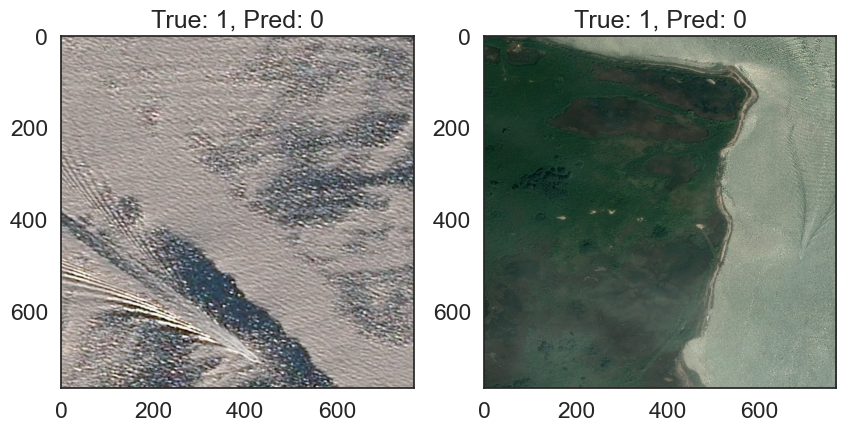

In [68]:
# Create a figure to display the results
plt.figure(figsize=(10, 5))

index_1 = 227
index_2 = 995
image_1 = load_image(test_names, index_1)
image_2 = load_image(test_names, index_2)

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(image_1.astype('float32'))
plt.title(f"True: {labels[index_1]}, Pred: {np_predictions[index_1]}")

plt.subplot(1, 2, 2)
plt.imshow(image_2.astype('float32'))
plt.title(f"True: {labels[index_2]}, Pred: {np_predictions[index_2]}")

## Conclusion

This project successfully developed a machine learning model based on the ResNet50 architecture to detect ships in satellite images from the Airbus Ship Detection Challenge dataset. Through careful preprocessing, model tuning, and rigorous evaluation, we achieved 95% accuracy in detecting the presence of ships. This achievement underscores the potential of using advanced deep learning techniques for ship detection, which has a large number of possible use cases. 

The higher recall (97%) versus precision (85%), indicates a slight tendency to predict that there are ships when the model is unsure. As the model was designed to find images that are likely to have ships, so that a second model could detect the number of ships in each image, this tendency is a positive. In this workflow the cost of missing a ship is high, therefore the fact that the model rarely misses a ship (low False Negative rate) is a strength.

## Further Enhancements

**Improving Model Accuracy:** Implement more complex image augmentation techniques to help the model generalize better over diverse lighting, weather conditions, and ship orientations. Explore the use of different architectures for potentially better feature extraction.

**Multiple Stage Model:** Add a second stage to the model pipeline which attempts to count the number of ships in each image. This could then be used to monitor ship activity in particular ports to estimate economic activity. 